In [1]:
"""Example showing the use of SOCEMO for multi-objective optimization"""

# Copyright (c) 2025 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__deprecated__ = False

# Multi-objective optimization

This example shows how to use the SOCEMO method to solve a one-dimensional multi-objective minimization problem. The method trains one RBF surrogate per objective, and use those to improve the knowledge about the Pareto front.

In this example, each objective is a sinusoidal function. The Pareto front is a small contiguous region close to one of the domain boundaries.

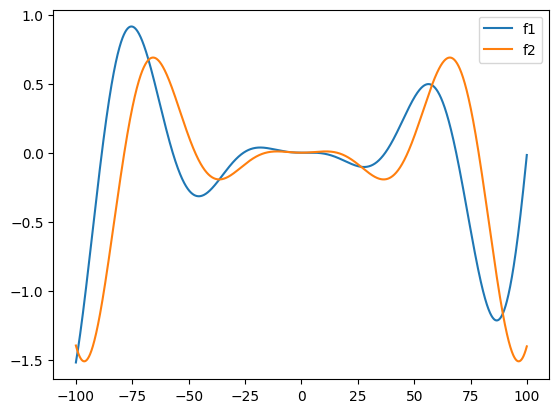

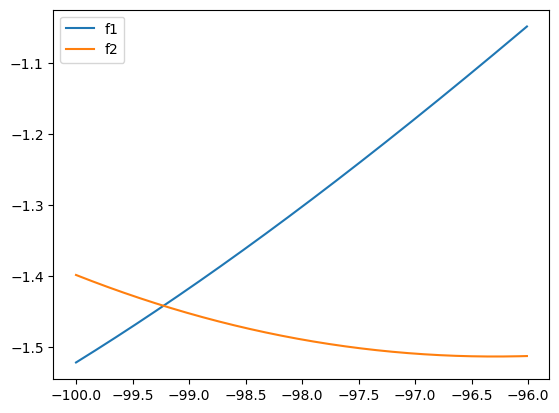

In [2]:
# Problem description
from matplotlib import pyplot as plt
import numpy as np

bounds = [(-100, 100)]


def objf(x):
    return [
        [
            xi[0] ** 2 * np.sin(0.1 * xi[0] - 10) / 6000,
            xi[0] ** 2 * np.cos(0.1 * xi[0]) / 6000,
        ]
        for xi in x
    ]


x = np.arange(-100, 100, 0.1)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label="f1")
plt.plot(x, f2x, label="f2")
plt.legend()
plt.show()

x = np.arange(-100, -96, 0.01)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label="f1")
plt.plot(x, f2x, label="f2")
plt.legend()
plt.show()

The local search in SOCEMO will use a normal distribution to perturb points in the Pareto front. The global search for other areas of interest in the space will use a uniform distribution. Both sampling strategies choose points that are `rtol` distant from current samples. The distance from neighbors is used in the fitness criterion for choosing new sample points (see `WeightedAcquisition`).

In [3]:
from soogo import RbfModel
from soogo.acquisition import WeightedAcquisition
from soogo.sampling import NormalSampler, Sampler

maxeval = 100
ncand = 500
sigma = 0.02
rtol = 0.01

localAcquisition = WeightedAcquisition(
    NormalSampler(ncand, sigma), weightpattern=0.95, rtol=rtol, maxeval=maxeval,
)
globalAcquisition = WeightedAcquisition(Sampler(ncand), 0.95)

In [4]:
# Declare variable so that the linter do not need to complain
outputSOCEMO = None

In this example, we want to obtain the surrogates used for the optimization. Thus, we need to create and pass by the interface a list of surrogates. We capture the verbose output from SOCEMO in the variable `outputSOCEMO`.

In [5]:
%%capture outputSOCEMO
from soogo import socemo

# Set random seed for reproducibility
np.random.seed(3)

# Run the optimization
surrogateModel = RbfModel()
res = socemo(
    objf,
    bounds,
    maxeval,
    surrogateModel=surrogateModel,
    acquisitionFunc=localAcquisition,
    acquisitionFuncGlobal=globalAcquisition,
    disp=True,
)

In [6]:
print(outputSOCEMO)

Iteration: 0
fEvals: 4
Time to update surrogate model: 0.000712 s
Fill gaps in the Pareto front: 1 points in 0.369446 s
Random perturbation of the currently nondominated points: 2 points in 0.000835 s
Minimum point sampling: 2 points in 0.255123 s
Uniform random points and scoring: 1 points in 0.000199 s
Solving the surrogate multiobjective problem: 4 points in 0.303035 s
Number of new sample points:  9
Iteration: 1
fEvals: 13
Time to update surrogate model: 0.000137 s
Fill gaps in the Pareto front: 1 points in 0.314842 s
Random perturbation of the currently nondominated points: 2 points in 0.001183 s
Minimum point sampling: 2 points in 0.240972 s
Uniform random points and scoring: 1 points in 0.000252 s
Solving the surrogate multiobjective problem: 2 points in 0.301380 s
Number of new sample points:  6
Iteration: 2
fEvals: 19
Time to update surrogate model: 0.000150 s
Fill gaps in the Pareto front: 1 points in 0.325167 s
Random perturbation of the currently nondominated points: 4 poin

Let us use the captured output from SOCEMO to extract information about the number of samples per iteration. That will help us to look at how samples were generated on each iteration of the algorithm.

In the curves below, $s_i$ denotes the surrogate model that approximates the i-th objective $f_i$.

In [7]:
out = outputSOCEMO.stdout.split("\n")

sampleUpToIter = []
for i in range(len(out)):
    if "fEvals:" in out[i]:
        sampleUpToIter.append(int(out[i].split()[1]))
sampleUpToIter.append(maxeval)

sampleUpToIter

[4,
 13,
 19,
 26,
 34,
 38,
 44,
 49,
 54,
 57,
 62,
 65,
 68,
 71,
 74,
 77,
 80,
 83,
 86,
 89,
 92,
 95,
 98,
 100]

Iteration 0:


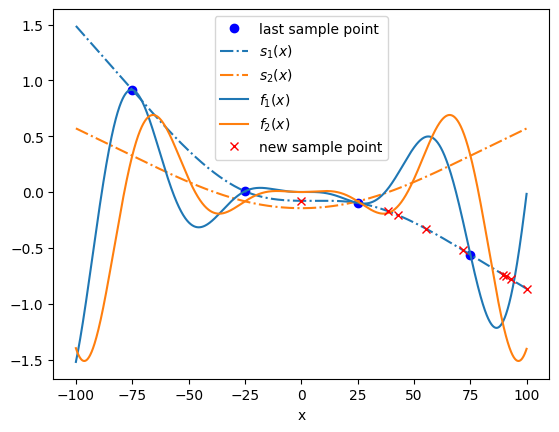

Iteration 1:


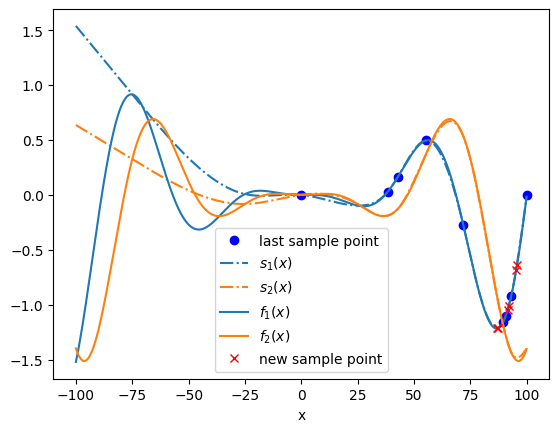

Iteration 2:


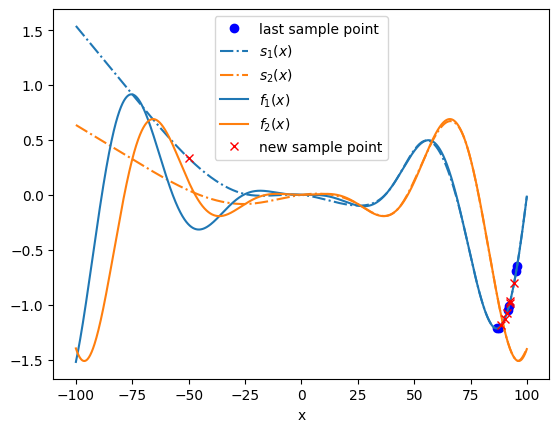

Iteration 3:


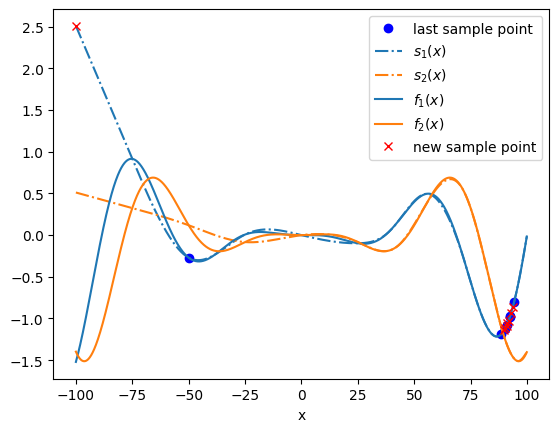

Iteration 4:


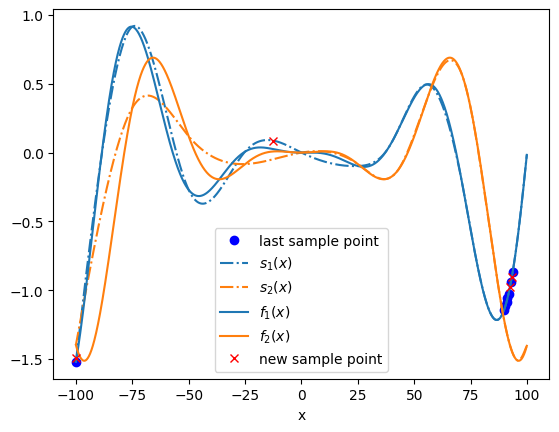

Iteration 5:


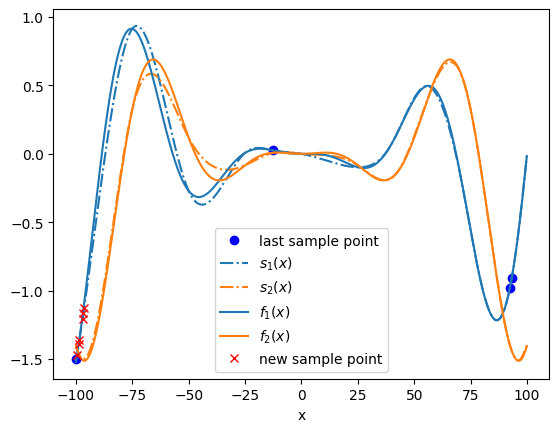

Iteration 6:


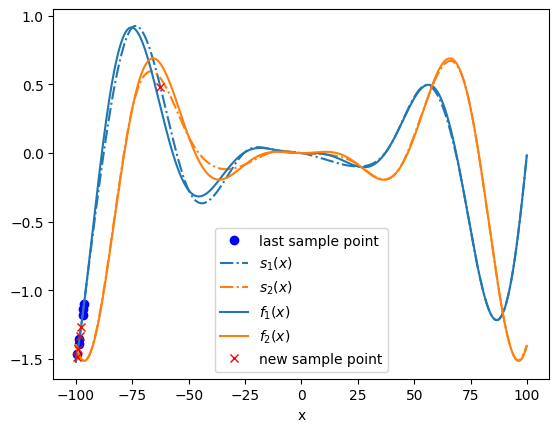

Iteration 7:


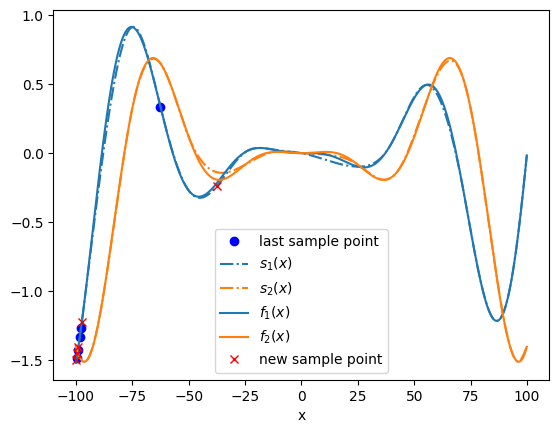

Iteration 8:


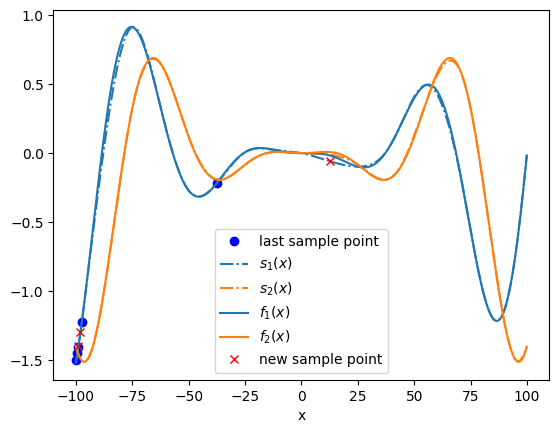

Iteration 9:


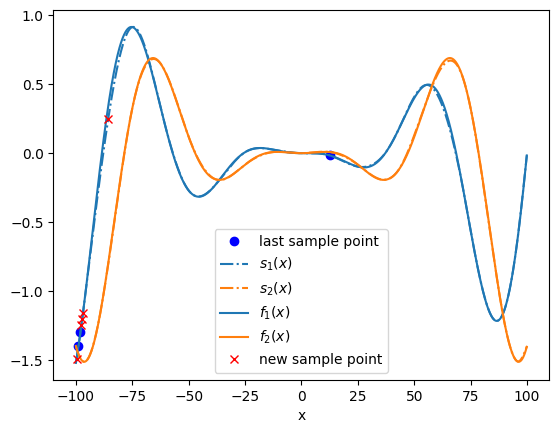

Iteration 10:


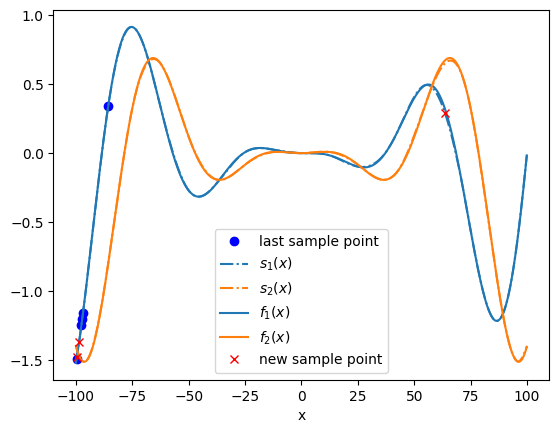

Iteration 11:


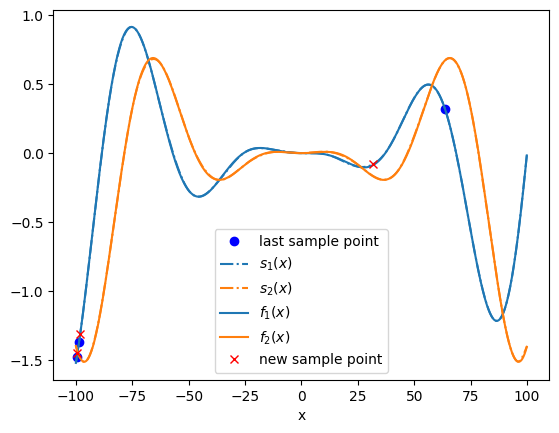

Iteration 12:


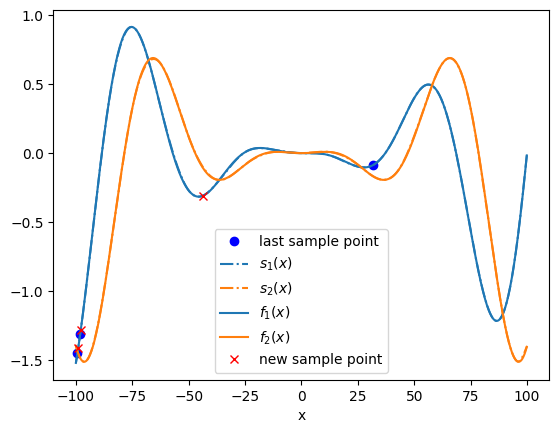

Iteration 13:


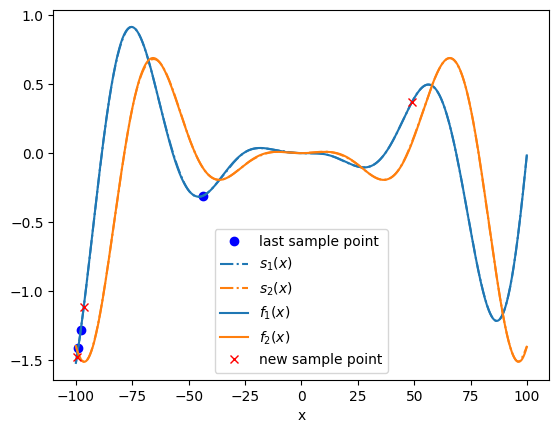

Iteration 14:


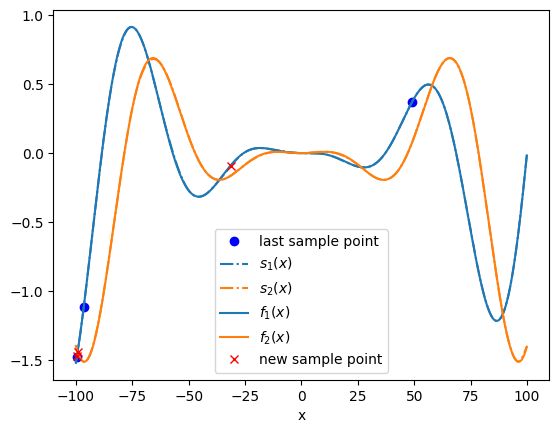

Iteration 15:


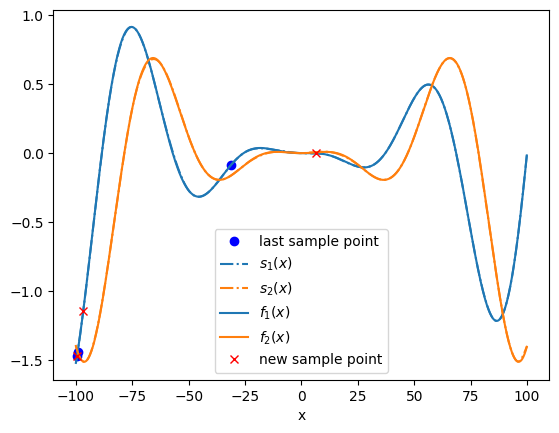

Iteration 16:


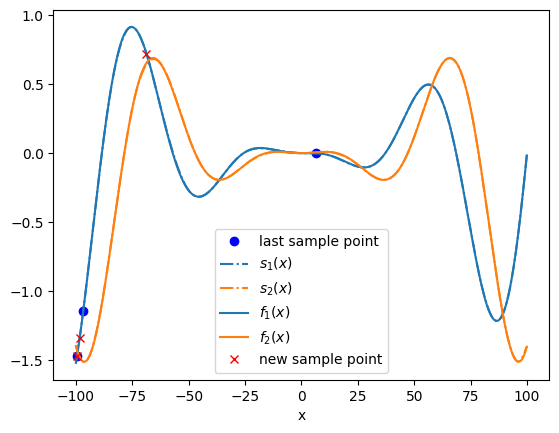

Iteration 17:


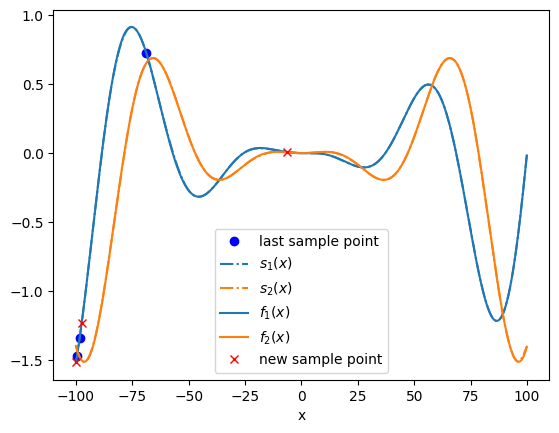

Iteration 18:


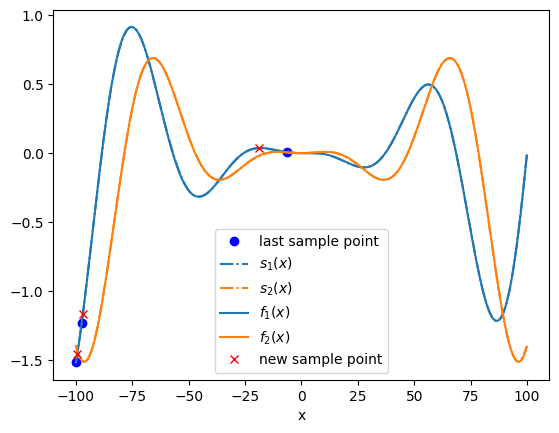

Iteration 19:


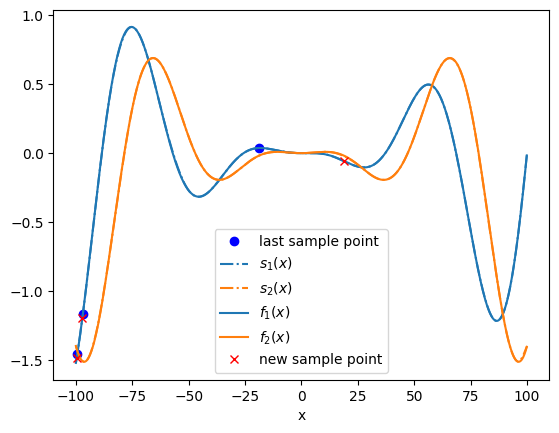

Iteration 20:


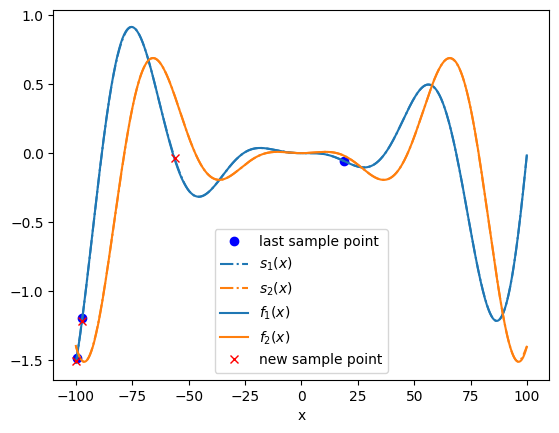

Iteration 21:


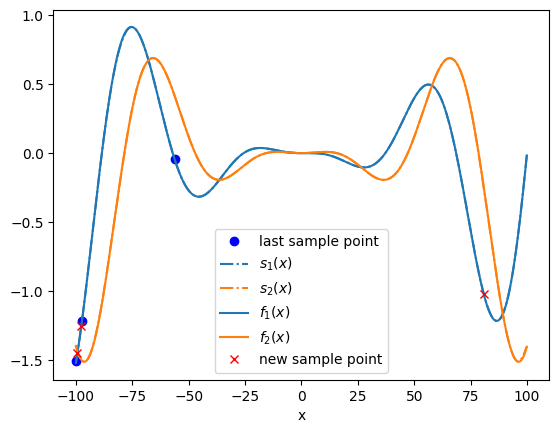

Iteration 22:


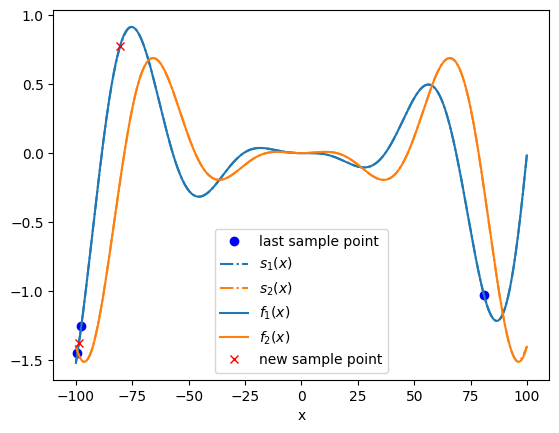

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

sample = res.sample.flatten()
f1 = res.fsample[:, 0].flatten()
f2 = res.fsample[:, 1].flatten()


def plotIteration(i):
    i0 = sampleUpToIter[i - 1] if i > 0 else 0
    i1 = sampleUpToIter[i]
    i2 = sampleUpToIter[i + 1]

    plt.plot(sample[i0:i1], f1[i0:i1], "bo", label="last sample point")
    # plt.plot(sample[i0:i1], f2[i0:i1], 'bo')

    s = RbfModel()
    s.update(res.sample[:i1], res.fsample[:i1])

    x = np.arange(-100, 100, 0.1).reshape(-1, 1)
    y1 = s(x,i=0)
    y2 = s(x,i=1)
    fx = objf(x)
    f1x = [f[0] for f in fx]
    f2x = [f[1] for f in fx]

    plt.plot(x.flatten(), y1, "-.", label=r"$s_1(x)$", color=colors[0])
    plt.plot(x.flatten(), y2, "-.", label=r"$s_2(x)$", color=colors[1])
    plt.plot(x.flatten(), f1x, "-", label=r"$f_1(x)$", color=colors[0])
    plt.plot(x.flatten(), f2x, "-", label=r"$f_2(x)$", color=colors[1])

    plt.plot(sample[i1:i2], s(np.array(sample[i1:i2]).T,i=0), "rx", label="new sample point")
    # plt.plot(sample[i1:i2], f2[i1:i2], 'rx')

    # plt.plot(sample[i1:i2], np.ones(i2-i1), 'ro', label="new sample")
    plt.xlabel("x")
    plt.legend()
    plt.show()


for i in range(len(sampleUpToIter) - 1):
    print(f"Iteration {i}:")
    plotIteration(i)

Now, let us look at the solution, i.e., the Pareto front that was predicted by the method. The Pareto front is the set of values of non-dominated inputs. An input $x$ is said to be dominated by $y$ if $f_i(y) < f_i(x)$ for all objective functions $f_i$. An input $x$ is non-dominated if there is no $y$ in the input domain such that $y$ dominates $x$.

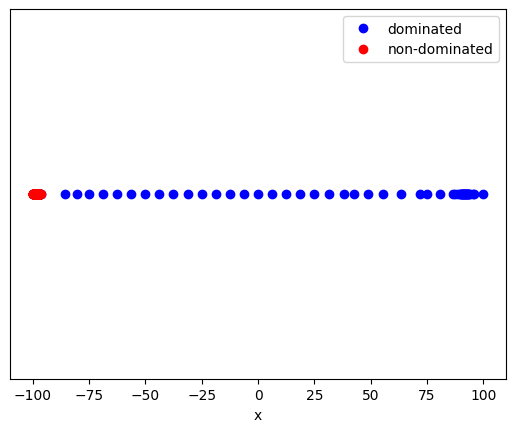

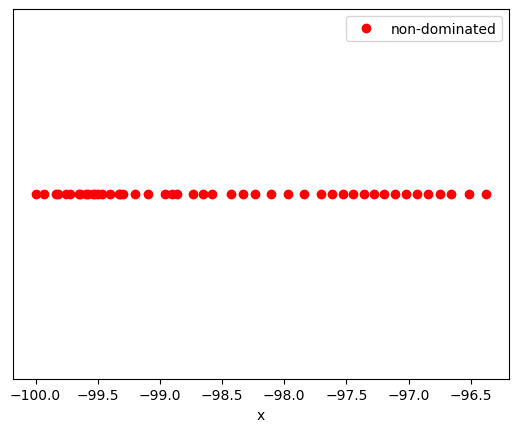

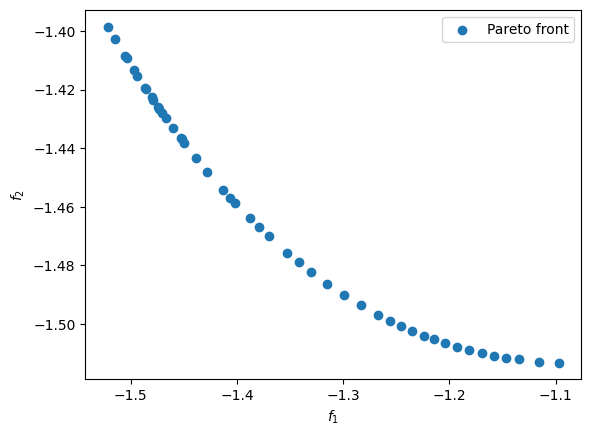

In [9]:
from matplotlib import pyplot as plt

nondominated = res.x
paretoFront = res.fx

plt.plot(sample, np.ones_like(sample), "bo", label="dominated")
# plt.plot(sample, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

# plt.scatter(res.fsample[:, 0], res.fsample[:, 1], label="Sample")
plt.scatter(res.fx[:, 0], res.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()

Since we kept the last surrogate models, we can continue optimization from where we stopped. Let us do a few more iterations. 

In [10]:
surrogateModel._x.shape

(100, 1)

In [11]:
# Continue optimization
print(f"Currently we have {surrogateModel.ntrain} sample points.")

maxeval2 = 30
localAcquisition.maxeval += maxeval2
res2 = socemo(
    objf,
    bounds,
    maxeval2,
    surrogateModel=surrogateModel,
    acquisitionFunc=localAcquisition,
    acquisitionFuncGlobal=globalAcquisition,
    disp=True,
)

Currently we have 100 sample points.
Iteration: 0
fEvals: 0
Time to update surrogate model: 0.000000 s
Fill gaps in the Pareto front: 1 points in 0.359236 s
Random perturbation of the currently nondominated points: 0 points in 0.041324 s
Minimum point sampling: 1 points in 0.409946 s
Uniform random points and scoring: 1 points in 0.001044 s
Solving the surrogate multiobjective problem: 0 points in 0.332413 s
Number of new sample points:  3
Iteration: 1
fEvals: 3
Time to update surrogate model: 0.000461 s
Fill gaps in the Pareto front: 1 points in 0.352119 s
Random perturbation of the currently nondominated points: 0 points in 0.042483 s
Minimum point sampling: 1 points in 0.437886 s
Uniform random points and scoring: 1 points in 0.000929 s
Solving the surrogate multiobjective problem: 0 points in 0.334912 s
Number of new sample points:  3
Iteration: 2
fEvals: 6
Time to update surrogate model: 0.000529 s
Fill gaps in the Pareto front: 1 points in 0.357876 s
Random perturbation of the cu

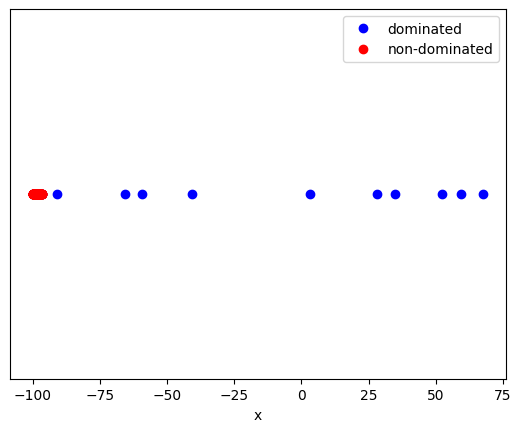

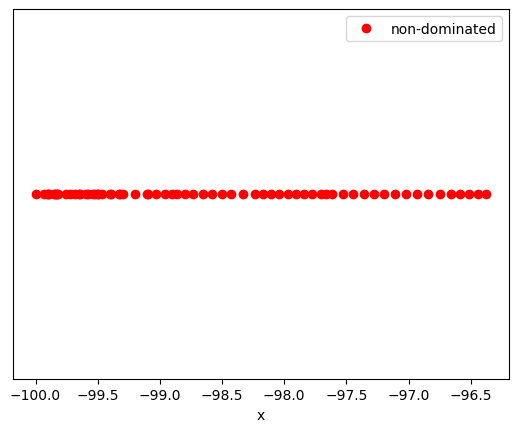

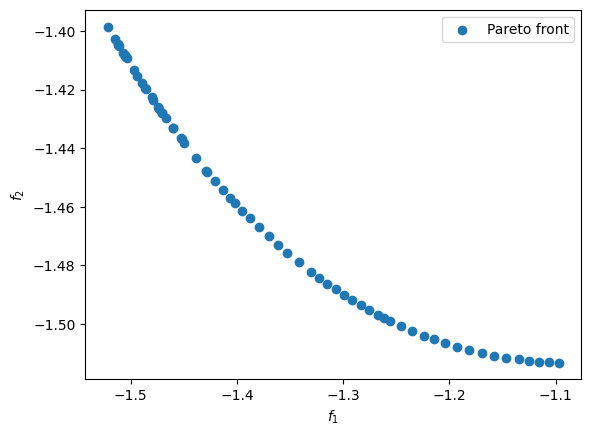

In [12]:
from matplotlib import pyplot as plt

sample = res2.sample.flatten()
f1 = res2.fsample[:, 0].flatten()
f2 = res2.fsample[:, 1].flatten()
nondominated = res2.x
paretoFront = res2.fx

plt.plot(sample, np.ones_like(sample), "bo", label="dominated")
# plt.plot(sample, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.scatter(res2.fx[:, 0], res2.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()